<a href="https://colab.research.google.com/github/peeyushsinghal/DA-CV/blob/main/SFEW_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Steps
1. Libraries
2. Dataset - read | create | show example
3. Dataloader - show example
4. Transforms - Normalize
5. Model - summary, pre-trained
6. Train Function
7. Test Function
Iteration 1
- Frozen weights, only changing the number of classes
Iteration 2
8. Training - One Cycle LR

In [1]:
!pip install torch-summary

In [2]:
# importing libraries
import torch
import torch.nn as nn
import torchvision
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from torchsummary import summary
from torchvision.datasets import ImageFolder # for datasets (reference: Sai's usage)
from torch.utils.data import DataLoader, Dataset
import os
import zipfile

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## DataSet
We are using SFEW dataset, which contains ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'] classes



In [4]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
BASE_PATH = '/content/drive/MyDrive/sfew'
EXTRACT_BASE_PATH = '/content/sample_data'
EXTRACT_DIR = os.path.join(EXTRACT_BASE_PATH,'sfew')
if not os.path.exists(EXTRACT_DIR):
  # create directory
  os.makedirs(EXTRACT_DIR)
  print(f'Directory {EXTRACT_DIR} created successfully.')
else:
    print(f'Directory {EXTRACT_DIR} already exists.')

Directory /content/sample_data/sfew created successfully.


In [6]:
# extracting data into EXTRACT_DIR
# Open the zip file
ZIP_FILE_PATH = os.path.join(BASE_PATH,'SFEW_2.zip')
with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
    # printing all the contents of the zip file
    zip_ref.printdir()
    # Extract all files to the specified directory
    zip_ref.extractall(EXTRACT_DIR)
print("File extraction complete.")

File Name                                             Modified             Size
Test/SFEW_2_Test.zip                           2015-07-08 14:11:20    199060703
Test/Test_Aligned_Faces.zip                    2015-07-08 12:20:40     11029890
Test/Test_Aligned_Points.zip                   2015-07-08 12:55:12       248998
Test/Test_LPQ_Features.zip                     2015-07-08 12:22:44       467744
Test/Test_PHOG_Features.zip                    2015-07-08 12:19:32      7259705
Train/Angry.zip                                2015-05-17 00:14:22     96754962
Train/Disgust.zip                              2015-05-17 12:41:38     32233965
Train/Fear.zip                                 2015-05-17 13:06:54     41873696
Train/Happy.zip                                2016-10-12 17:15:44    119766884
Train/Neutral.zip                              2015-05-17 02:07:38     82149409
Train/Sad.zip                                  2015-05-17 12:25:48    101196826
Train/Surprise.zip                      

In [7]:
labels=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

In [8]:
# finding directories after unzip in EXTRACT_DIR
print(os.listdir(EXTRACT_DIR))
dict_dataset = {'TRAIN_DIR' : os.path.join(EXTRACT_DIR,'Train'),
                'TEST_DIR' : os.path.join(EXTRACT_DIR,'Test'),
                'VAL_DIR' : os.path.join(EXTRACT_DIR,'Val')}

for dir_name, dir in dict_dataset.items():
  for zips in os.listdir(dir):
    temp_file_name = (zips).split(".")[0]
    if temp_file_name in labels:
      print (dir, zips, temp_file_name)
      with zipfile.ZipFile(os.path.join(dir,zips), 'r') as zip_ref:
        zip_ref.extractall(dir)
        print(f'...completed for {dir}/{zip}')


['Val', 'Test', 'Train']
/content/sample_data/sfew/Train Disgust.zip Disgust
...completed for /content/sample_data/sfew/Train/<class 'zip'>
/content/sample_data/sfew/Train Surprise.zip Surprise
...completed for /content/sample_data/sfew/Train/<class 'zip'>
/content/sample_data/sfew/Train Neutral.zip Neutral
...completed for /content/sample_data/sfew/Train/<class 'zip'>
/content/sample_data/sfew/Train Fear.zip Fear
...completed for /content/sample_data/sfew/Train/<class 'zip'>
/content/sample_data/sfew/Train Angry.zip Angry
...completed for /content/sample_data/sfew/Train/<class 'zip'>
/content/sample_data/sfew/Train Happy.zip Happy
...completed for /content/sample_data/sfew/Train/<class 'zip'>
/content/sample_data/sfew/Train Sad.zip Sad
...completed for /content/sample_data/sfew/Train/<class 'zip'>
/content/sample_data/sfew/Val Disgust.zip Disgust
...completed for /content/sample_data/sfew/Val/<class 'zip'>
/content/sample_data/sfew/Val Surprise.zip Surprise
...completed for /content/s

In [9]:
## creating a dataset without transforms to understand mean and std deviation.
train_pre_norm_ds = ImageFolder(root=dict_dataset['TRAIN_DIR'],
                       transform=transforms.ToTensor())
print(f'Number of images in train_ds: {len(train_pre_norm_ds)}')

Number of images in train_ds: 958


In [10]:
import torch

def compute_mean_std(dataset):
    # Initialize variables
    mean = torch.zeros(3)  # Assuming RGB images (3 channels)
    std = torch.zeros(3)

    # Iterate over the dataset
    for sample in dataset:
        image = sample[0]  # Access the image from the sample
        mean += torch.mean(image, dim=(1, 2))  # Compute mean along height and width dimensions
        std += torch.std(image, dim=(1, 2))  # Compute standard deviation along height and width dimensions

    # Divide by the number of samples
    mean /= len(dataset)
    std /= len(dataset)

    return mean, std

# Assuming you have a dataset object 'dataset' (e.g., ImageFolder or custom dataset)
mean, std = compute_mean_std(train_pre_norm_ds)

print("Mean:", mean)
print("Standard Deviation:", std)

Mean: tensor([0.2197, 0.1858, 0.1569])
Standard Deviation: tensor([0.1810, 0.1635, 0.1511])


In [11]:
def get_mean_std_dev(dataset):
  '''
  get mean and std deviation of dataset
  '''
  loader = DataLoader(dataset,
                      batch_size = 1,
                      num_workers=1,
                      shuffle = False)
  mean, std, num_samples = 0.0, 0.0, 0.0
  for images, _ in loader:
    batch_size = images.size(0)
    images = images.view(batch_size, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    num_samples += batch_size

  mean /= num_samples
  std /= num_samples
  print("Mean:", mean)
  print("Standard Deviation:", std)
  return mean.numpy(), std.numpy()

In [12]:
mean_ds, std_dev_ds = get_mean_std_dev(train_pre_norm_ds)
print(f'mean_ds = {mean_ds}, std_dev_ds ={std_dev_ds}')

Mean: tensor([0.2197, 0.1858, 0.1569])
Standard Deviation: tensor([0.1810, 0.1635, 0.1511])
mean_ds = [0.21972586 0.18580976 0.15688032], std_dev_ds =[0.18099076 0.1634635  0.15109721]


In [13]:
# Train Phase transformations
#TODO: Use albumentations in later versions, first iteration does not include any transformations
train_transforms = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                      #  transforms.RandomCrop(224, padding=10, padding_mode='reflect'),
                                      #  transforms.RandomHorizontalFlip(),
                                      #  transforms.RandomRotation(5),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean_ds, std_dev_ds)
                                       ])

# Val Phase transformations
val_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean_ds, std_dev_ds)
                                     ])

In [14]:
# dataset
train_ds = ImageFolder(root=dict_dataset['TRAIN_DIR'],
                       transform=train_transforms)
val_ds = ImageFolder(root=dict_dataset['VAL_DIR'],
                       transform=val_transforms)

In [15]:
for sample in train_pre_norm_ds:
  print(sample[0])
  break
for sample in train_ds:
  print(sample[0])
  break

tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0118],
         [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0118, 0.0078],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0078, 0.0078],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0196],
         [0.0039, 0.0039, 0.0039,  ..., 0.0078, 0.0118, 0.0078],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0078, 0.0078],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0196],
         [0.0039, 0.0039, 0.0039,  ..., 0.0078, 0.0118, 0.

In [16]:
compute_mean_std(train_ds)
get_mean_std_dev(train_ds)

Mean: tensor([0.0003, 0.0003, 0.0003])
Standard Deviation: tensor([0.9863, 0.9849, 0.9826])


(array([0.00029253, 0.00031168, 0.00026504], dtype=float32),
 array([0.9862985 , 0.9849104 , 0.98256457], dtype=float32))

In [17]:
SEED = 42

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
BATCH_SIZE = 16
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=BATCH_SIZE)

# train dataloader
train_loader = DataLoader(train_ds, **dataloader_args)

# test dataloader
val_loader = DataLoader(val_ds, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [18]:
import matplotlib.pyplot as plt
import numpy as np

def show_batch(dataset_loader,label_names,num_images=5):
  '''
  shows a batch of images (default = 5)
  '''
  images, targets = next(iter(dataset_loader))
  plt.figure(figsize=(16, 8))
  for i in range(num_images):
    ax = plt.subplot(int(num_images//5)+1, 5, i + 1)
    images[i] = images[i] / 2 + 0.5 # unnormalize, though not the best way
    ax.imshow(images[i].permute(1, 2, 0))
    plt.title(label_names[targets[i]])
    plt.axis("off")

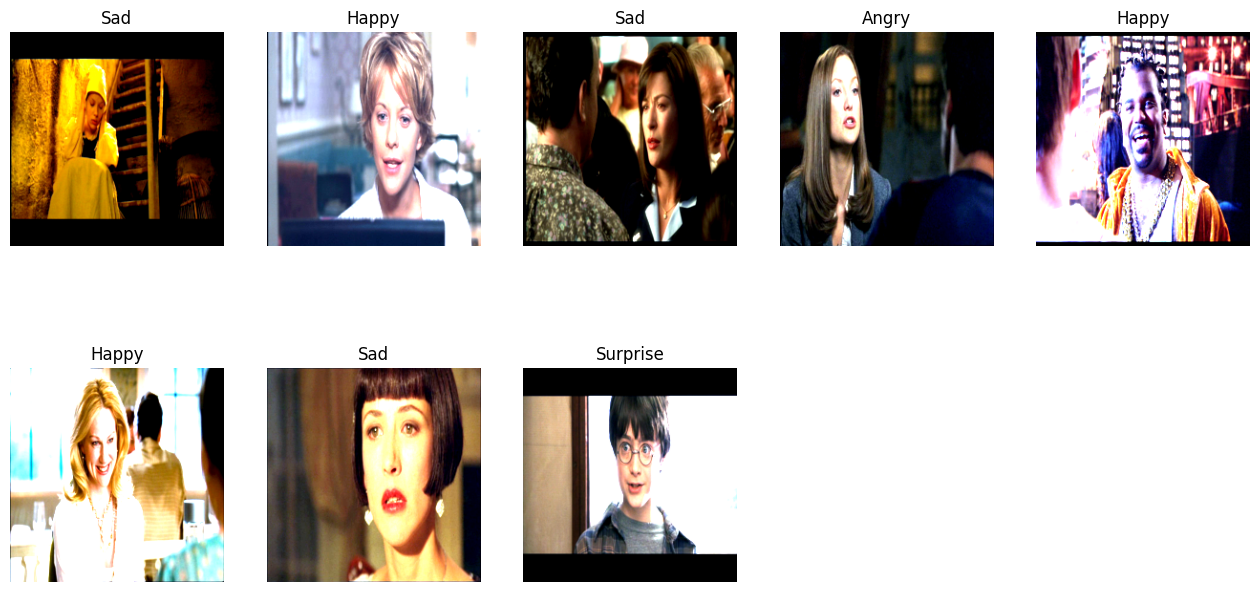

In [19]:
show_batch(train_loader,labels,8)

## Model

In [20]:
# Load pretrained resnet50 (reference: https://pytorch.org/vision/main/models.html )
model_1 = resnet50(weights=ResNet50_Weights.DEFAULT).to(device) # original model
# # summary of the model
# summary(model_1, input_size=(3, 224, 224), depth = 3)
print (model_1) # to understand names and modules of the model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 229MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Iteration 1
- Use pre-trained weights, freezing weights
- No changes in feature extraction layer
- Number of output changed to the number of classes, i.e. 7

In [21]:
# Freeze model parameters
for param in model_1.parameters():
    param.requires_grad = False

# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = model_1.fc.in_features
model_1.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 7),
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

In [22]:
print(model_1) # checking if the FC layer has changed

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
model_1 = model_1.to(device)

In [24]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01, momentum=0.9) # SGD is good for CV task #TODO : Try Adam

In [25]:
import torch
import torch.nn as nn
from tqdm import tqdm # for beautiful model training updates


def trainer(model,device, trainloader, testloader, optimizer,epochs,criterion,scheduler):
  train_losses = [] # to capture train losses over training epochs
  train_accuracy = [] # to capture train accuracy over training epochs
  test_losses = [] # to capture test losses
  test_accuracy = [] # to capture test accuracy
  for epoch in range(epochs):
    print("EPOCH:", epoch+1)
    train(model, device, trainloader, optimizer, epoch,criterion,train_accuracy,train_losses,scheduler) # Training Function
    test(model, device, testloader,criterion,test_accuracy,test_losses)   # Test Function

  return train_accuracy, train_losses, test_accuracy, test_losses


# # Training Function
def train(model, device, train_loader, optimizer, epoch,criterion,train_accuracy,train_losses,scheduler = None):
  model.train() # setting the model in training
  pbar = tqdm(train_loader) # putting the iterator in pbar
  correct = 0 # for accuracy numerator
  processed =0 # for accuracy denominator

  for batch_idx, (images,labels) in enumerate(pbar):
    images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
    optimizer.zero_grad() # setting gradients to zero to avoid accumulation

    y_preds = model(images) # forward pass, result captured in y_preds (plural as there are many images in a batch)
    # the predictions are in one hot vector

    loss = criterion(y_preds,labels) # capturing loss

    train_losses.append(loss) # to capture loss over many epochs

    loss.backward() # backpropagation
    optimizer.step() # updating the params

    if scheduler:
      if not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step()

    preds = y_preds.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += preds.eq(labels.view_as(preds)).sum().item()
    processed += len(images)


    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_accuracy.append(100*correct/processed)


# # Test Function
def test(model, device, test_loader,criterion,test_accuracy,test_losses) :
  model.eval() # setting the model in evaluation mode
  test_loss = 0
  correct = 0 # for accuracy numerator

  with torch.no_grad():
    for (images,labels) in test_loader:
      images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
      outputs = model(images) # forward pass, result captured in outputs (plural as there are many images in a batch)
      # the outputs are in batch size x one hot vector

      test_loss = criterion(outputs,labels).item()  # sum up batch loss
      preds = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += preds.eq(labels.view_as(preds)).sum().item()

    test_loss /= len(test_loader.dataset) # average test loss
    test_losses.append(test_loss) # to capture loss over many batches

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

    test_accuracy.append(100*correct/len(test_loader.dataset))

In [27]:
 model_1 = model_1.to(device)
 EPOCHS = 20
 train_accuracy, train_losses, test_accuracy, test_losses = trainer(model = model_1,
                                                                    device = device,
                                                                    trainloader = train_loader,
                                                                    testloader = val_loader,
                                                                    optimizer = optimizer,
                                                                    epochs = EPOCHS,
                                                                    criterion = loss_func,
                                                                    scheduler= None)

EPOCH: 1


Loss=1.2005304098129272 Batch_id=59 Accuracy=59.08: 100%|██████████| 60/60 [00:11<00:00,  5.21it/s]



Test set: Average loss: 0.0064, Accuracy: 106/436 (24.31%)

EPOCH: 2


Loss=1.1153945922851562 Batch_id=59 Accuracy=66.91: 100%|██████████| 60/60 [00:08<00:00,  7.08it/s]



Test set: Average loss: 0.0052, Accuracy: 106/436 (24.31%)

EPOCH: 3


Loss=0.7901210188865662 Batch_id=59 Accuracy=71.40: 100%|██████████| 60/60 [00:06<00:00,  8.82it/s]



Test set: Average loss: 0.0079, Accuracy: 102/436 (23.39%)

EPOCH: 4


Loss=1.0373092889785767 Batch_id=59 Accuracy=74.22: 100%|██████████| 60/60 [00:06<00:00,  9.02it/s]



Test set: Average loss: 0.0044, Accuracy: 85/436 (19.50%)

EPOCH: 5


Loss=0.3408103585243225 Batch_id=59 Accuracy=76.10: 100%|██████████| 60/60 [00:07<00:00,  7.74it/s]



Test set: Average loss: 0.0028, Accuracy: 97/436 (22.25%)

EPOCH: 6


Loss=0.809841513633728 Batch_id=59 Accuracy=77.56: 100%|██████████| 60/60 [00:08<00:00,  7.03it/s]



Test set: Average loss: 0.0036, Accuracy: 105/436 (24.08%)

EPOCH: 7


Loss=0.655704140663147 Batch_id=59 Accuracy=80.69: 100%|██████████| 60/60 [00:07<00:00,  7.85it/s]



Test set: Average loss: 0.0124, Accuracy: 101/436 (23.17%)

EPOCH: 8


Loss=0.503121554851532 Batch_id=59 Accuracy=83.09: 100%|██████████| 60/60 [00:06<00:00,  9.10it/s]



Test set: Average loss: 0.0062, Accuracy: 103/436 (23.62%)

EPOCH: 9


Loss=0.45865538716316223 Batch_id=59 Accuracy=85.80: 100%|██████████| 60/60 [00:07<00:00,  8.37it/s]



Test set: Average loss: 0.0048, Accuracy: 112/436 (25.69%)

EPOCH: 10


Loss=0.7347167730331421 Batch_id=59 Accuracy=85.70: 100%|██████████| 60/60 [00:08<00:00,  7.15it/s]



Test set: Average loss: 0.0070, Accuracy: 101/436 (23.17%)

EPOCH: 11


Loss=0.4459790587425232 Batch_id=59 Accuracy=89.04: 100%|██████████| 60/60 [00:07<00:00,  7.59it/s]



Test set: Average loss: 0.0059, Accuracy: 78/436 (17.89%)

EPOCH: 12


Loss=0.4799085259437561 Batch_id=59 Accuracy=89.14: 100%|██████████| 60/60 [00:06<00:00,  9.05it/s]



Test set: Average loss: 0.0086, Accuracy: 95/436 (21.79%)

EPOCH: 13


Loss=0.3080880343914032 Batch_id=59 Accuracy=88.94: 100%|██████████| 60/60 [00:07<00:00,  8.50it/s]



Test set: Average loss: 0.0044, Accuracy: 104/436 (23.85%)

EPOCH: 14


Loss=0.24272044003009796 Batch_id=59 Accuracy=91.44: 100%|██████████| 60/60 [00:08<00:00,  7.08it/s]



Test set: Average loss: 0.0044, Accuracy: 105/436 (24.08%)

EPOCH: 15


Loss=0.14334164559841156 Batch_id=59 Accuracy=91.23: 100%|██████████| 60/60 [00:08<00:00,  7.12it/s]



Test set: Average loss: 0.0073, Accuracy: 104/436 (23.85%)

EPOCH: 16


Loss=0.24063074588775635 Batch_id=59 Accuracy=92.80: 100%|██████████| 60/60 [00:06<00:00,  8.95it/s]



Test set: Average loss: 0.0079, Accuracy: 94/436 (21.56%)

EPOCH: 17


Loss=0.2624075710773468 Batch_id=59 Accuracy=93.32: 100%|██████████| 60/60 [00:06<00:00,  8.91it/s]



Test set: Average loss: 0.0082, Accuracy: 99/436 (22.71%)

EPOCH: 18


Loss=0.1282361000776291 Batch_id=59 Accuracy=89.77: 100%|██████████| 60/60 [00:09<00:00,  6.35it/s]



Test set: Average loss: 0.0059, Accuracy: 99/436 (22.71%)

EPOCH: 19


Loss=0.5125629305839539 Batch_id=59 Accuracy=94.36: 100%|██████████| 60/60 [00:08<00:00,  6.90it/s]



Test set: Average loss: 0.0060, Accuracy: 91/436 (20.87%)

EPOCH: 20


Loss=0.7229887843132019 Batch_id=59 Accuracy=94.78: 100%|██████████| 60/60 [00:07<00:00,  8.04it/s]



Test set: Average loss: 0.0061, Accuracy: 102/436 (23.39%)



## Checking training and results

In [30]:
import seaborn as sns

def plot_metrics(train_accuracy, train_losses, test_accuracy, test_losses):
    sns.set(font_scale=1)
    plt.rcParams["figure.figsize"] = (25,6)

    # Plot the learning curve.
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(np.array(train_losses), 'b', label="Train Loss")

    # Label the plot.
    ax1.set_title("Train Loss")
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(np.array(train_accuracy), 'b', label="Train Accuracy")

    # Label the plot.
    ax2.set_title("Train Accuracy")
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("Loss")
    ax2.legend()

    plt.show()

    # Plot the learning curve.
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(np.array(test_losses), 'b', label="Test Loss")

    # Label the plot.
    ax1.set_title("Test Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(np.array(test_accuracy), 'b', label="Test Accuracy")

    # Label the plot.
    ax2.set_title("Test Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()

    plt.show()

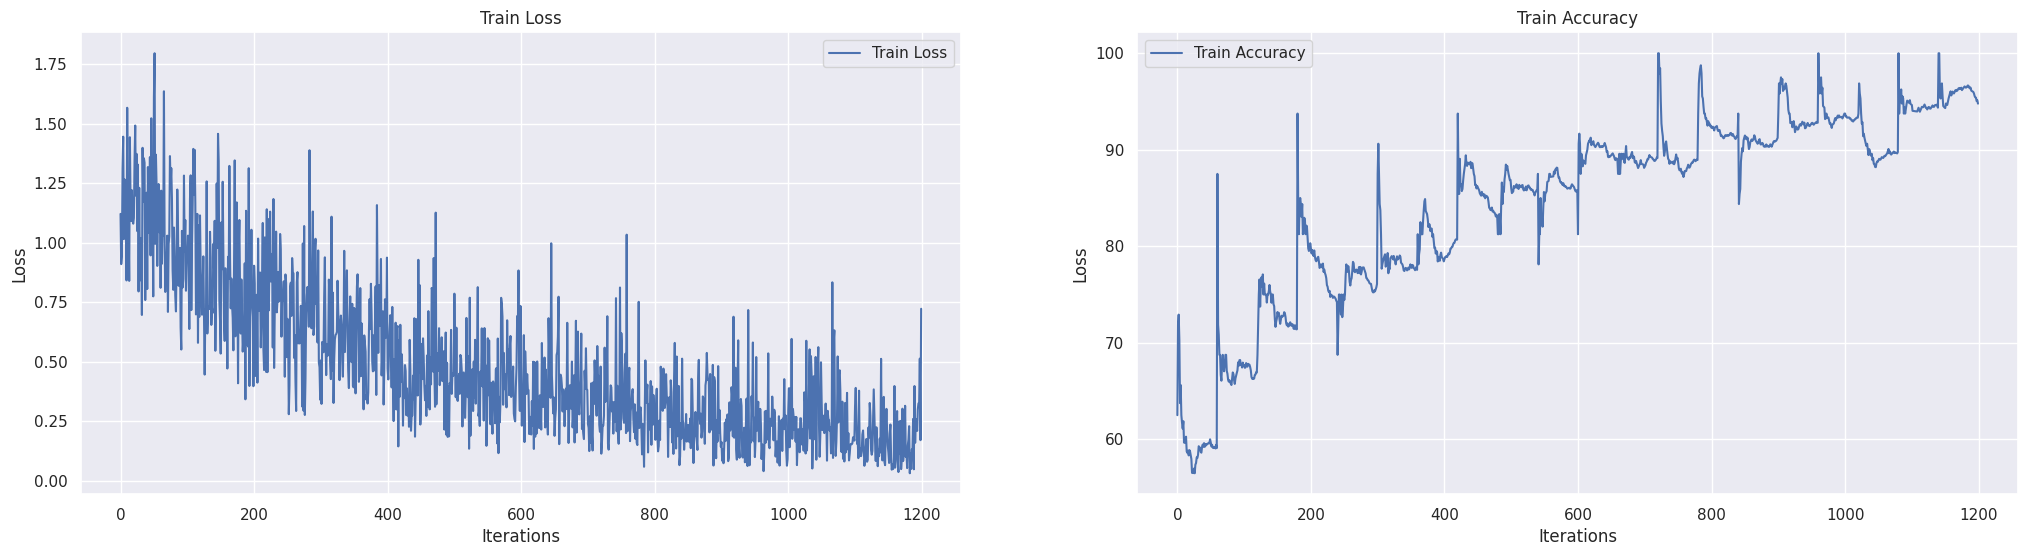

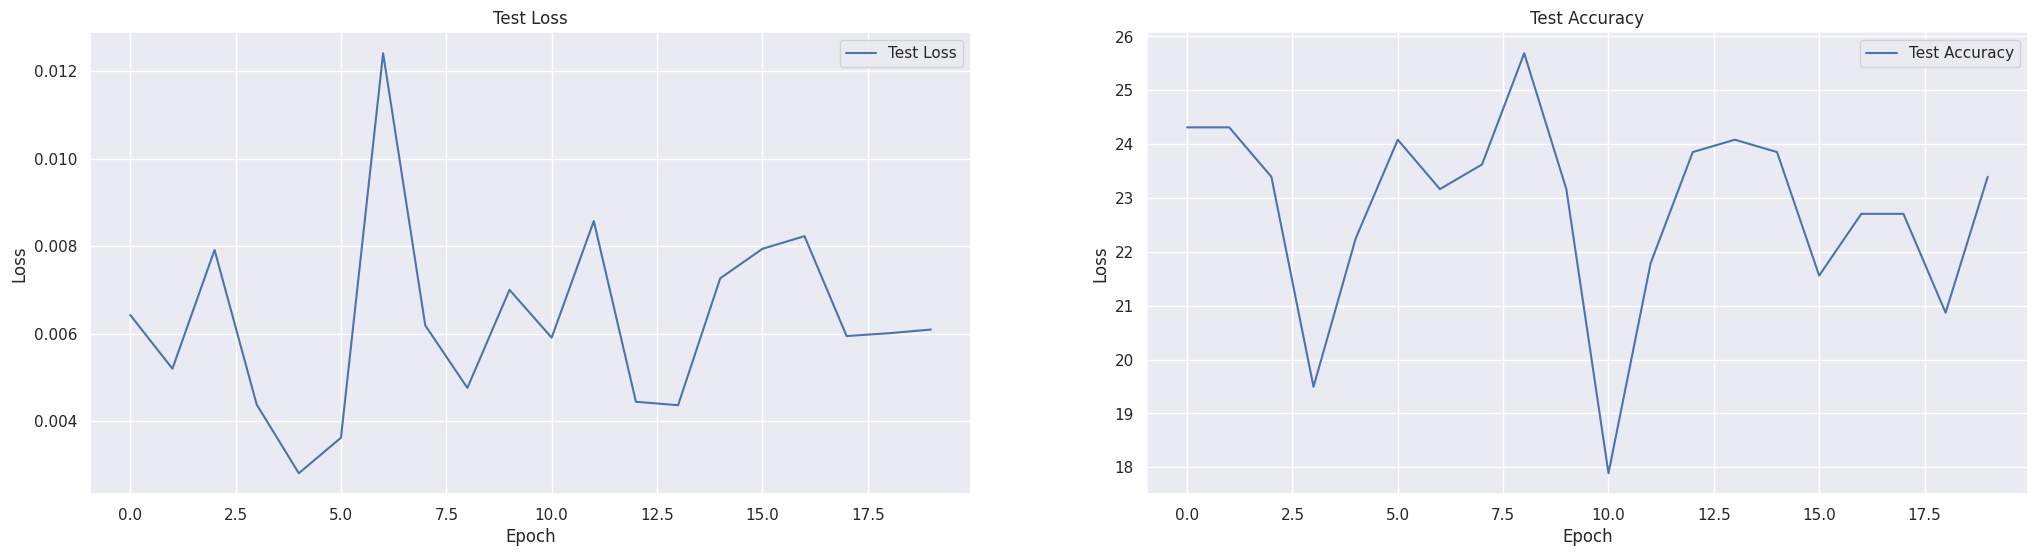

In [32]:
plot_metrics(train_accuracy, [x.cpu().detach().numpy() for x in train_losses], test_accuracy, test_losses)


### Classwise accuracy

In [37]:
def evaluate_classwise_accuracy(model, device, classes, test_loader):
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
            	label = labels[i]
            	class_correct[label] += c[i].item()
            	class_total[label] += 1

    for i in range(len(classes)):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [38]:
evaluate_classwise_accuracy(model_1, device, labels, val_loader)

Accuracy of Angry : 38 %
Accuracy of Disgust :  0 %
Accuracy of  Fear : 14 %
Accuracy of Happy : 25 %
Accuracy of Neutral : 44 %
Accuracy of   Sad : 34 %
Accuracy of Surprise :  0 %


### Misclassified Images

In [42]:
def plot_misclassified_images(wrong_predictions, mean, std, n_images=20, class_names=None):
    """
    Plot the misclassified images.
    """
    if class_names is None:
        class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    fig = plt.figure(figsize=(10, 12))
    fig.tight_layout()
    for i, (img, pred, correct) in enumerate(wrong_predictions[:n_images]):
        img, pred, target = img.cpu().numpy().astype(dtype=np.float32), pred.cpu(), correct.cpu()
        for j in range(img.shape[0]):
            img[j] = (img[j] * std[j]) + mean[j]

        img = np.transpose(img, (1, 2, 0))
        ax = fig.add_subplot(5, 5, i + 1)
        ax.axis("off")
        ax.set_title(f"\nactual : {class_names[target.item()]}\npredicted : {class_names[pred.item()]}", fontsize=10)
        ax.imshow(img)

    plt.show()

def misclassified_images(model, test_loader, device, mean, std, class_names=None, n_images=20):
    """
    Get misclassified images.
    """
    wrong_images = []
    wrong_label = []
    correct_label = []
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True).squeeze()  # get the index of the max log-probability

            wrong_pred = pred.eq(target.view_as(pred)) == False
            wrong_images.append(data[wrong_pred])
            wrong_label.append(pred[wrong_pred])
            correct_label.append(target.view_as(pred)[wrong_pred])

            wrong_predictions = list(zip(torch.cat(wrong_images), torch.cat(wrong_label), torch.cat(correct_label)))
        print(f"Total wrong predictions are {len(wrong_predictions)}")

        plot_misclassified_images(wrong_predictions, mean, std, n_images=n_images, class_names=class_names)

    return wrong_predictions



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Total wrong predictions are 334


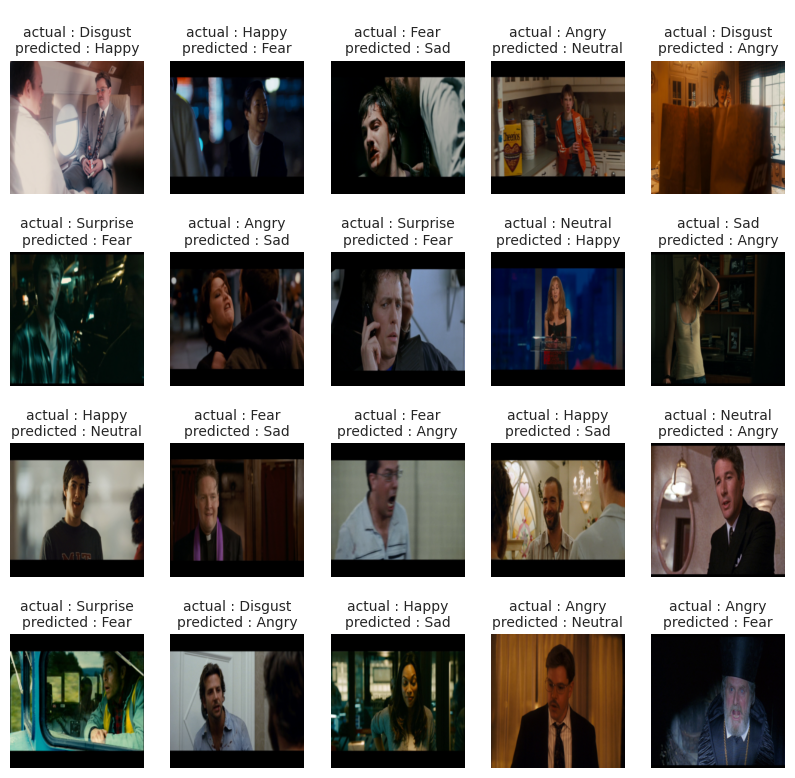

In [45]:
images_misclassified = misclassified_images(model_1, val_loader, device, mean_ds, std_dev_ds , class_names=labels)